<a href="https://colab.research.google.com/github/strna8/public-data-cpi-supplement-analysis/blob/main/supplement_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:108: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layou

[저장 완료] cpi_healthfood_세항목_월간(2020=100).csv
[저장 완료] cpi_healthfood_세항목_yoy.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

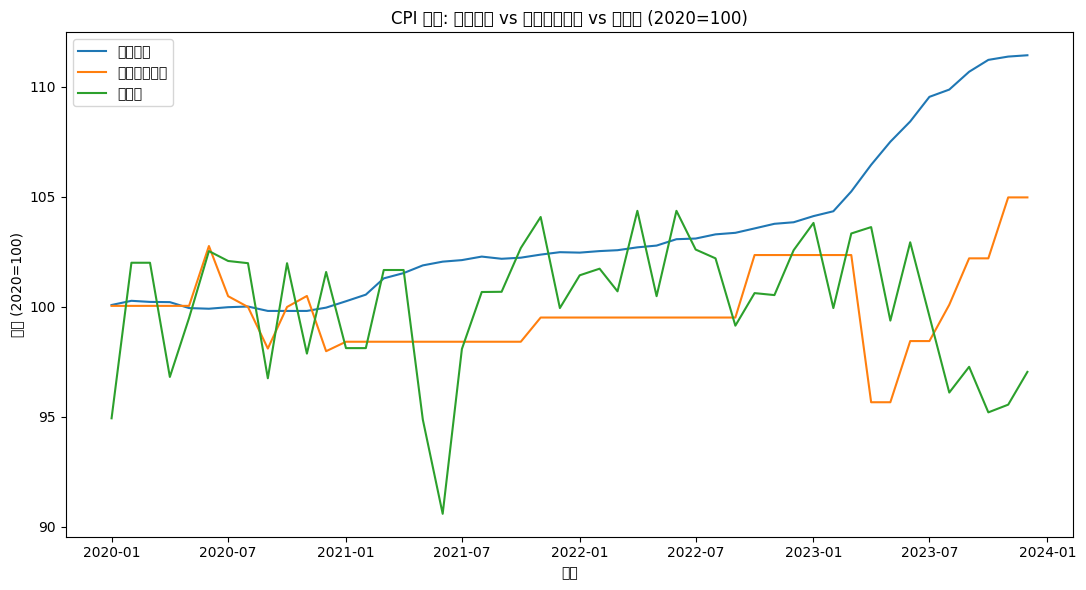

/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3552880279.py:123: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.ti

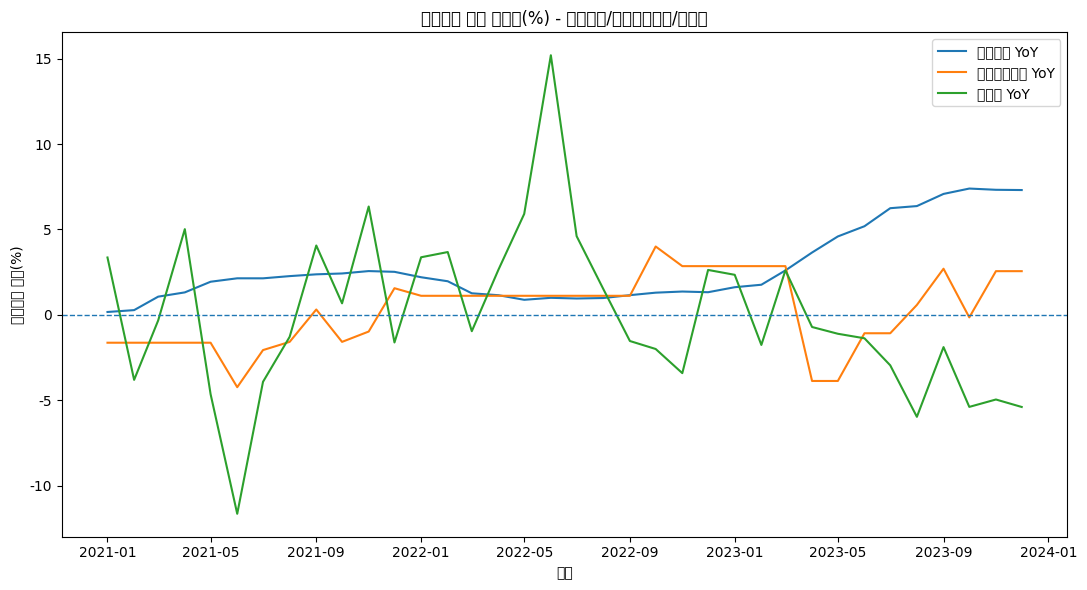

In [3]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager as fm
from functools import reduce

# -------------------- 사용자 설정 --------------------
API_KEY = "******************"          # 본인 키
TABLE   = "901Y009"                        # CPI (2020=100)
START, END = "202001", "202312"            # 수집 구간 (YYYYMM)

series = {
    "비타민제":     "F01113",
    "건강기능식품": "F01114",
    "유산균":       "F01115",
}

BASE = "https://ecos.bok.or.kr/api/StatisticSearch"

SAVE_RAW_CSV = "cpi_healthfood_세항목_월간(2020=100).csv"
SAVE_YOY_CSV = "cpi_healthfood_세항목_yoy.csv"

# -----------------------------------------------------

def setup_korean_font():
    """OS에 설치된 한글 폰트를 자동 선택. 실패 시 DejaVu Sans 유지."""
    # 선호 순서
    preferred = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR"]
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in preferred:
        if name in installed:
            rcParams["font.family"] = [name]
            break
    else:
        # 폰트가 하나도 없으면 경고만 띄우고 기본 폰트 유지
        print("[경고] 한글 폰트(Malgun/Apple/Nanum/Noto)가 설치되어 있지 않습니다. 글자가 깨질 수 있어요.")
        rcParams["font.family"] = ["DejaVu Sans"]
    rcParams["axes.unicode_minus"] = False  # 음수 기호 깨짐 방지

def _get_with_retry(url, max_retry=3, backoff=2, timeout=20):
    """간단 재시도 래퍼"""
    last_err = None
    for i in range(max_retry):
        try:
            resp = requests.get(url, timeout=timeout)
            resp.raise_for_status()
            return resp.json()
        except Exception as e:
            last_err = e
            if i < max_retry - 1:
                time.sleep(backoff ** i)
    raise RuntimeError(f"요청 실패: {url}\n{last_err}")

def fetch_series(item_code: str) -> pd.DataFrame:
    """ECOS API에서 단일 품목 코드 수집 -> (date, value) DataFrame"""
    url = f"{BASE}/{API_KEY}/json/kr/1/10000/{TABLE}/M/{START}/{END}/{item_code}"
    data = _get_with_retry(url)

    # 에러/구조 방어
    if isinstance(data, dict) and "RESULT" in data:
        raise RuntimeError(f"[{item_code}] API 오류: {data['RESULT']}")
    if "StatisticSearch" not in data or "row" not in data["StatisticSearch"]:
        raise RuntimeError(f"[{item_code}] 응답 구조 이상: {list(data.keys())}")

    rows = pd.DataFrame(data["StatisticSearch"]["row"])
    if rows.empty:
        raise RuntimeError(f"[{item_code}] 데이터 없음")

    rows["date"]  = pd.to_datetime(rows["TIME"], format="%Y%m")
    rows["value"] = pd.to_numeric(rows["DATA_VALUE"], errors="coerce")
    rows = (
        rows[["date", "value"]]
        .dropna()
        .drop_duplicates(subset=["date"])
        .sort_values("date")
    )
    return rows

def build_panel(series_map: dict) -> pd.DataFrame:
    """여러 품목 코드를 수집해 날짜 기준으로 outer merge"""
    dfs = []
    for name, code in series_map.items():
        s = fetch_series(code).rename(columns={"value": name})
        dfs.append(s)
    panel = reduce(lambda l, r: pd.merge(l, r, on="date", how="outer"), dfs)
    panel = panel.sort_values("date").reset_index(drop=True)
    return panel

def compute_yoy(df: pd.DataFrame, date_col="date") -> pd.DataFrame:
    """각 컬럼의 전년동월(YoY %) 계산"""
    yoy = df.set_index(date_col).pct_change(12) * 100
    yoy = yoy.add_suffix("_YoY(%)").reset_index()
    return yoy

def plot_index(df: pd.DataFrame, title: str):
    plt.figure(figsize=(11, 6))
    x = df["date"]
    for col in df.columns:
        if col == "date":
            continue
        plt.plot(x, df[col], label=col)
    plt.title(title)
    plt.xlabel("날짜")
    plt.ylabel("지수 (2020=100)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_yoy(yoy: pd.DataFrame, title: str):
    plt.figure(figsize=(11, 6))
    x = yoy["date"]
    for col in yoy.columns:
        if col == "date":
            continue
        plt.plot(x, yoy[col], label=col.replace("_YoY(%)", " YoY"))
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("날짜")
    plt.ylabel("전년동월 대비(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # setup_korean_font() # This line is no longer needed after setting the font globally

    # 1) 수집 & 병합
    panel = build_panel(series)

    # 2) YoY 파생
    yoy = compute_yoy(panel, date_col="date")

    # 3) 저장
    panel.to_csv(SAVE_RAW_CSV, index=False)
    yoy.to_csv(SAVE_YOY_CSV, index=False)
    print(f"[저장 완료] {SAVE_RAW_CSV}")
    print(f"[저장 완료] {SAVE_YOY_CSV}")

    # 4) 시각화
    plot_index(panel, "CPI 비교: 비타민제 vs 건강기능식품 vs 유산균 (2020=100)")
    plot_yoy(yoy, "전년동월 대비 변동률(%) - 비타민제/건강기능식품/유산균")

if __name__ == "__main__":
    main()